In [1]:
%matplotlib inline

import glob, os, sys, math, copy, joblib, shap, NaiveDE, SpatialDE, lime, cv2
import zipfile, skimage, warnings, json, re, glob, shutil, anndata 
import scanpy as sc
import squidpy as sq

import scipy as sp
from scipy import ndimage as ndi
from scipy.stats import fisher_exact, nbinom
from statsmodels.stats.contingency_tables import mcnemar

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm as cm

import numpy as np
from PIL import Image
from tqdm import tqdm
from typing import Optional, Union
from numpy import array, argmax, load

from matplotlib import pyplot as plt
from PIL import Image
from io import BytesIO
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, jaccard_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image as image_fun
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, Lambda

from skimage.transform import resize
from skimage.color import rgb2hed
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries, watershed, mark_boundaries
from skimage.morphology import area_opening
from scipy.ndimage import label as nuclei_count
from lime import lime_image

from libpysal.weights.contiguity import Queen
from libpysal import examples
from esda.moran import Moran
import geopandas as gpd

import splot
from splot.esda import moran_scatterplot, lisa_cluster
from esda.moran import Moran, Moran_Local
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation

import warnings
warnings.filterwarnings("ignore")

In [3]:
Path = "/home/uqomulay/90days/STimage_outputs/"

images_WEBTOOL = []
image_dir = glob.glob(os.path.join(Path, "LIME/FFPE_Immune/*.jpeg")) + glob.glob(os.path.join(Path, "LIME/FFPE_Cancer/*.jpeg"))
for image in image_dir:
    images_WEBTOOL.append(np.asarray(image_fun.load_img(image)))

In [4]:
def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=80)
    thresh = skimage.filters.threshold_otsu(annotation_h)
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)
    map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
    im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)
    return im_nuclei_seg_mask

def LIME_reg(image_path, gene):
    LIME_masks = []; LIME_heatmaps = []
    for i in image_path:
        image = np.asarray(image_fun.load_img(i))
        explanation = explainer.explain_instance(image, model_predict_gene_reg(gene), top_labels=1, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
        temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=100, hide_rest=True)
        mask[mask<=0] = 0
        LIME_masks.append(mask)
        dict_heatmap = dict(explanation.local_exp[0])
        heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
        LIME_heatmaps.append(heatmap)
    return LIME_masks, LIME_heatmaps

def LIME(image_path, gene):
    LIME_masks = []; LIME_heatmaps = []
    for i in image_path:
        image = np.asarray(image_fun.load_img(i))
        explanation = explainer.explain_instance(image, model_predict_gene(gene), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
        temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=100, hide_rest=True)
        mask[mask<=0] = 0
        LIME_masks.append(mask)
        dict_heatmap = dict(explanation.local_exp[1])
        heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
        LIME_heatmaps.append(heatmap)
    return LIME_masks, LIME_heatmaps

def true_tumor_nuclie_mask(img_path):
    true_tumor_mask = []
    for i in img_path:
        image = cv2.imread(i)
        lower = np.array([0, 255, 0], dtype="uint8")
        upper = np.array([0, 255, 0], dtype="uint8")
        mask = cv2.inRange(image, lower, upper)
        mask[mask==255] = 1
        true_tumor_mask.append(mask)
    return true_tumor_mask

def true_immune_nuclei_mask(img_path):
    true_immune_mask = []
    for i in img_path:
        image = cv2.imread(i)
        image[:,:,1] = 0
        mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mask[mask==105] = 0
        mask[mask>0] = 1
        true_immune_mask.append(mask)
    return true_immune_mask

def lime_masks_combined(masks, genes):
    masks_genes_total = np.add.reduceat(masks, np.arange(0, len(masks), len(genes)))
    masks_genes_mask = copy.copy(masks_genes_total)
    for i in range(0,len(masks_genes_mask)):
        masks_genes_mask[i] = np.where(masks_genes_mask[i] > (len(genes)/2),1,0)
    return masks_genes_total, masks_genes_mask

def heatmaps_combined(heatmaps, genes):
    heatmap_genes_total = np.add.reduceat(heatmaps, np.arange(0, len(heatmaps), len(genes)))
    return heatmap_genes_total

def model_predict_gene_nb(gene, gene_list, model):
    i = gene_list.index(gene)
    def model_predict(x):
        test_predictions = model.predict(x)
        n = test_predictions[i][:, 0]
        p = test_predictions[i][:, 1]
        y_pred = nbinom.mean(n, p)
        return y_pred.reshape(-1,1)
    return model_predict

def model_predict_gene(gene):
    i = gene_list.index(gene)
    def combine_model_predict(tile1):
        feature1 = resnet_model.predict(tile1)
        prediction = clf_resnet.predict_proba(feature1)
        return prediction[i]
    return combine_model_predict

resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(299, 299, 3), pooling="avg")
clf_resnet = joblib.load(Path+'pickle/LRmodel.pkl')
explainer = lime_image.LimeImageExplainer()

2022-07-22 11:50:17.105284: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def CNN_NB_multiple_genes(tile_shape, n_genes, cnnbase="resnet50", ft=False):

    tile_input = Input(shape=tile_shape, name="tile_input")
    if cnnbase == "resnet50":
        cnn_base = ResNet50(input_tensor=tile_input, weights='imagenet', include_top=False)
    elif cnnbase == "vgg16":
        cnn_base = VGG16(input_tensor=tile_input, weights='imagenet', include_top=False)
    elif cnnbase == "inceptionv3":
        cnn_base = InceptionV3(input_tensor=tile_input, weights='imagenet', include_top=False)
    elif cnnbase == "mobilenetv2":
        cnn_base = MobileNetV2(input_tensor=tile_input, weights='imagenet', include_top=False)
    elif cnnbase == "densenet121":
        cnn_base = DenseNet121(input_tensor=tile_input, weights='imagenet', include_top=False)
    elif cnnbase == "xception":
        cnn_base = Xception(input_tensor=tile_input, weights='imagenet', include_top=False)
    if not ft:
        for i in cnn_base.layers:
            i.trainable = False
    cnn = cnn_base.output
    cnn = GlobalAveragePooling2D()(cnn)
    output_layers = []
    for i in range(n_genes):
        output = Dense(2)(cnn)
        output_layers.append(Lambda(negative_binomial_layer, name="gene_{}".format(i))(output))

    model = Model(inputs=tile_input, outputs=output_layers)
    optimizer = tf.keras.optimizers.Adam(1e-5)
    model.compile(loss=negative_binomial_loss,
                  optimizer=optimizer)
    return model


def negative_binomial_loss(y_true, y_pred):

    # Separate the parameters
    n, p = tf.unstack(y_pred, num=2, axis=-1)
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)
    nll = (
            tf.math.lgamma(n)
            + tf.math.lgamma(y_true + 1)
            - tf.math.lgamma(n + y_true)
            - n * tf.math.log(p)
            - y_true * tf.math.log(1 - p)
    )
    return nll

def negative_binomial_layer(x):

    num_dims = len(x.get_shape())
    n, p = tf.unstack(x, num=2, axis=-1)
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)
    n = tf.keras.activations.softplus(n)
    p = tf.keras.activations.sigmoid(p)
    out_tensor = tf.concat((n, p), axis=num_dims - 1)
    return out_tensor

#model = CNN_NB_multiple_genes((299, 299, 3), len(gene_list))
model = tf.keras.models.load_model("/afm01/UQ/Q2051/STimage_project/pretrained_model/CNN_NB_9visium_14_markers.h5",custom_objects = {"negative_binomial_loss": negative_binomial_loss})

In [7]:
gene_list_reg = ["IGHG3", "IGHM", "C3", "AP2B1", "GNAS", "PRLR", "PUM1"]

In [50]:
image = image_fun.load_img("/home/uqomulay/90days/STimage_outputs/LIME/FFPE_Immune/FFPE-8619-16760-299.jpeg")
explanation = explainer.explain_instance(np.array(image), model_predict_gene_nb("GNAS", gene_list_reg, model), top_labels=1, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=100, hide_rest=True)
mask[mask<=0] = 0
LIME_masks.append(mask)
dict_heatmap = dict(explanation.local_exp[0])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
LIME_heatmaps.append(heatmap)

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Input y contains NaN.

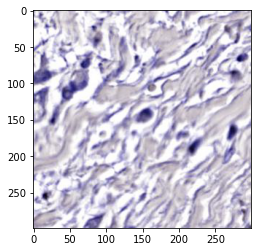

In [40]:
plt.imshow(image)

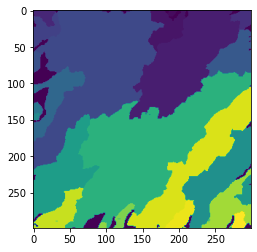

In [41]:
image = image_fun.load_img("/home/uqomulay/90days/STimage_outputs/LIME/FFPE_Immune/FFPE-8619-16760-299.jpeg")
plt.imshow(watershed_segment(np.array(image)))